In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import os
import C
from pyomo.environ import *
from pyomo.dae import *
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import time
print("import completed")

import completed


                t          x
count   21.000000  21.000000
mean    88.000000  17.942177
std     49.638695   3.982831
min      8.000000  10.000000
25%     48.000000  15.535714
50%     88.000000  18.571429
75%    128.000000  21.071429
max    168.000000  23.928571
R^2:  38.0 %
Fitted parameters are below :
       Xm=37.674062644158276 and Um=0.12127155273755318


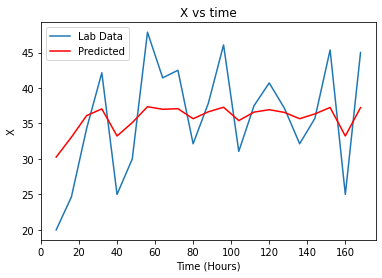

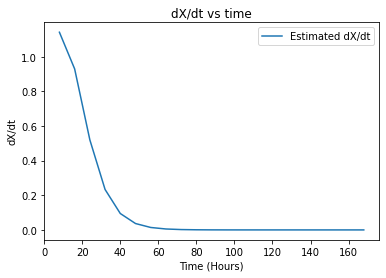

In [2]:
# x vs t
path=os.getcwd()+"//"
data_x_vs_t=pd.read_excel(path+"data.xlsx",sheet_name="x_vs_t")
print(data_x_vs_t.describe())

# X vs t
def x_vs_t(X,Xm,Um):
    t=X
    return Xm/(1+((Xm/C.X0)-1)*np.exp(-Um*t))

# dxdt vs time
def dXdt_vs_time(X,Xm,Um):
    t=X
    X1=x_vs_t(X,Xm,Um)
    return Um*X1*(1-X1/Xm)

g=[184,.33]
t=data_x_vs_t["t"].values
X=data_x_vs_t["x"].values
X=X*2 # scaling
g,cov=curve_fit(x_vs_t,t,X,g)
y =[x_vs_t(t,g[0],g[1]) for t in X]
Xm,Um=g[0],g[1]
print('R^2: ', 100*round(r2_score(X,y),2),"%")

print("Fitted parameters are below :")
print("       Xm={0} and Um={1}".format(g[0],g[1]))

plt.plot(t,X,label="Lab Data")
plt.plot(t,y,'r',label="Predicted")
plt.ylabel("X")
plt.xlabel("Time (Hours)")
plt.title("X vs time")
plt.legend()
plt.show()

plt.plot(t,dXdt_vs_time(t,g[0],g[1]),label='Estimated dX/dt')
plt.ylabel("dX/dt")
plt.xlabel("Time (Hours)")
plt.title("dX/dt vs time")
plt.legend()
plt.show()

               t        co2
count   23.00000  23.000000
mean    66.00000   0.167411
std     40.69398   0.096106
min      0.00000   0.005357
25%     33.00000   0.066964
50%     66.00000   0.198214
75%     99.00000   0.251786
max    132.00000   0.294643
R^2:  85.3 %
Fitted parameters are below :
       Yxco2=6.945910771712754 and Mco2=0.005718539483980408


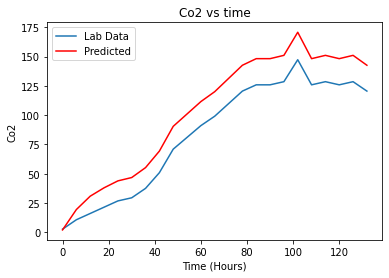

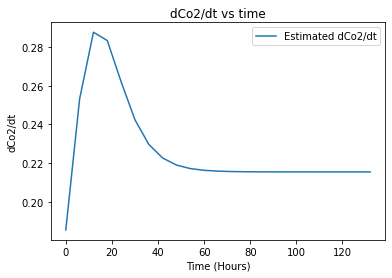

In [3]:
####### co2 vs t
path=os.getcwd()+"//"
data_co2_vs_t=pd.read_excel(path+"data.xlsx",sheet_name="co2_vs_t")
print(data_co2_vs_t.describe())

# CO2 vs t
def co2_vs_t(X,Yxco2,Mco2):
    Xm,Um=184,.33
    t=X
    comn=1+((Xm/C.X0)-1)*np.exp(-Um*t)
    RHS1=1/(Yxco2*comn)
    RHS2=1/(Yxco2*(Xm/C.X0))
    RHS3=(Mco2/Um)*np.log(comn/((Xm/C.X0)*np.exp(-Um*t)))
    return C.CCP0+Xm*(RHS1-RHS2+RHS3)

# dco2dt vs time
def dco2dt_vs_t(X,Yxco2,Mco2,Xm,Um):
    #Xm,Um=184,.33
    t=X
    comn=1+((Xm/C.X0)-1)*np.exp(-Um*t)
    RHS1=Um/Yxco2
    RHS2=RHS1*(1-1/(comn))
    RHS3=RHS2+Mco2
    return RHS3*Xm/comn

g=[2.60,.005]
t=data_co2_vs_t["t"].values
X=data_co2_vs_t["co2"].values
X=500*X #scaling
g,cov=curve_fit(co2_vs_t,t,X,g)
y =[co2_vs_t(t,g[0],g[1]) for t in X]
Yxco2,Mco2=g[0],g[1]

print('R^2: ', round(100*r2_score(y,X),2),"%")
print("Fitted parameters are below :")
print("       Yxco2={0} and Mco2={1}".format(g[0],g[1]))

plt.plot(t,X,label='Lab Data')
plt.plot(t,y,'r',label='Predicted')
plt.xlabel("Time (Hours)")
plt.ylabel("Co2")
plt.title("Co2 vs time")
plt.legend()
plt.show()

plt.plot(t,dco2dt_vs_t(t,Yxco2,Mco2,Xm,Um),label='Estimated dCo2/dt')
plt.xlabel("Time (Hours)")
plt.ylabel("dCo2/dt")
plt.title("dCo2/dt vs time")
plt.legend()
plt.show()


In [4]:
### Heat Equation
m = ConcreteModel()
m.t = ContinuousSet(bounds=(0,200))
m.z = ContinuousSet(bounds=(0,C.Z))
m.r = ContinuousSet(bounds=(0,C.R))
m.T = Var(m.z,m.r,m.t)
m.u = Var(m.z,m.r,m.t)
# PDEs
m.dTdz   = DerivativeVar(m.T,wrt=m.z)
m.d2Tdz2 = DerivativeVar(m.T,wrt=(m.z,m.z))
m.dTdr   = DerivativeVar(m.T,wrt=m.r)
m.d2Tdr2 = DerivativeVar(m.T,wrt=(m.r,m.r))
m.dTdt   = DerivativeVar(m.T,wrt=m.t)

# equations
def X(m):
    return "C.Xm/(1+((C.Xm/C.X0)-1)*exp(-C.Um*k))"
def dXdt(m):
    return "C.Um*{0}*(1-{1}/C.Xm)".format(X(m),X(m))
def dHdT1(m):
    return ".62413*C.b*C.p"
def dHdT2(m):
    return "(m.T[i,j,k]+C.c)**2"
def dHdT3(m):
    return "C.d*exp(C.a-C.b/(m.T[i,j,k]+C.c))"
def dHdT4(m):
    return "(C.p/{0}-1)**2".format(dHdT3(m))
def dHdT(m):
    return "{0}/({1}*{2}*{3})".format(dHdT1(m),dHdT2(m),dHdT4(m),dHdT3(m))
def Cpb(m):
    return "(C.epi*C.rhoA*(C.Cpa+C.lmbda*{0}+(1-C.epi)*C.rhoS*C.Cps))/C.rhoB".format(dHdT(m))
def heRHS(m):
    return "C.rhoB*{0}*m.dTdt[i,j,k]".format(Cpb(m))
def heLHS1(m):
    return "C.rhoS*(1-C.epi)*C.YQ*{0}".format(dXdt(m))
def heLHS2(m):
    return "C.rhoA*C.Cpa*C.Vz*m.dTdz[i,j,k]"
def heLHS3(m):
    return "C.rhoA*C.lmbda*C.Vz*{0}*m.dTdz[i,j,k]".format(dHdT(m))
def heLHS4(m):
    return "C.Kb*m.d2Tdz2[i,j,k]"
def heLHS5(m):
    return "C.Kb*m.dTdr[i,j,k]/(.01+j)+C.Kb*m.d2Tdr2[i,j,k]"

# heat equation
def _heateq(m,i,j,k):
    eqString=heLHS1(m)+"-"+heLHS2(m)+"-"+heLHS3(m)+"+"+heLHS4(m)+"+"+heLHS5(m)+"=="+heRHS(m)
    #print(eqString)
    #print("Please wait. I'm solving complex 3D heat equation")
    return eval(eqString)
m.heateq = Constraint(m.z,m.r,m.t,rule=_heateq)

# IC
def _initT(m,i,j):
    return m.T[i,j,0] == C.T0
m.initT = Constraint(m.z,m.r,rule=_initT)

# BCs
def _zl_bound(m,j,k):
    return m.T[0,j,k] == C.Ta 
m.zl_bound = Constraint(m.r,m.t,rule=_zl_bound)

def _zu_bound(m,j,k):
    return m.dTdz[C.Z,j,k] == 0
m.zu_bound = Constraint(m.r,m.t,rule=_zu_bound)

def _rl_bound(m,i,k):
    return m.dTdz[i,0,k] == 0
m.rl_bound = Constraint(m.z,m.t,rule=_rl_bound)

def _ru_bound(m,i,k):
    return C.Kb*m.dTdr[i,C.R,k]+C.h*(m.T[i,C.R,k]-C.Tj)==0
m.ru_bound = Constraint(m.z,m.t,rule=_ru_bound)

# Dummy objective fn
m.obj = Objective(expr=1)

# Discretize using Finite Difference Method
discretizer = TransformationFactory('dae.finite_difference')
discretizer.apply_to(m,nfe=20,wrt=m.z,scheme='CENTRAL')
discretizer.apply_to(m,nfe=20,wrt=m.r,scheme='CENTRAL')
discretizer.apply_to(m,nfe=20,wrt=m.t,scheme='CENTRAL')

# solve system of ODEs
solver=SolverFactory('ipopt')
results = solver.solve(m,tee=True)

# output
out=[]
for i in sorted(m.t):
    for j in sorted(m.z):
        for k in sorted(m.r):
            out.append([i,j,k,value(m.T[j,k,i])])
outDF=pd.DataFrame(out,columns=["t","z","r","T"])
outDF=outDF.sort_values(by="t")

Ipopt 3.12.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   200655
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    27783

Total number of variables............................:    55566
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

In [5]:
# Temprature data summary
print(outDF.describe())

                 t            z            r            T
count  9261.000000  9261.000000  9261.000000  9261.000000
mean    100.000000     0.500000     0.133350    33.506622
std      60.556277     0.302781     0.080752     0.034117
min       0.000000     0.000000     0.000000    33.455312
25%      50.000000     0.250000     0.066675    33.499973
50%     100.000000     0.500000     0.133350    33.500000
75%     150.000000     0.750000     0.200025    33.500000
max     200.000000     1.000000     0.266700    33.809838


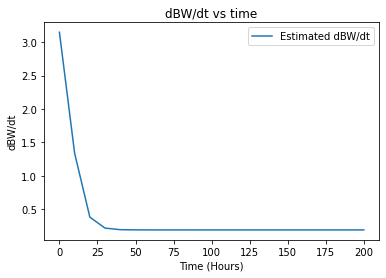

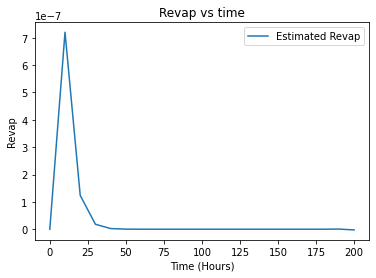

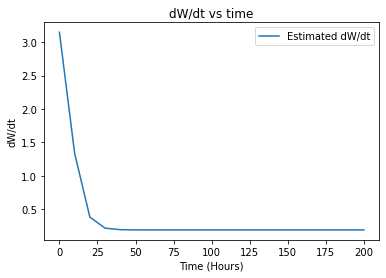

In [6]:
###### bed water

# X vs t
def x_vs_t(t,Xm,Um):
    try :
        return Xm/(1+((Xm/C.X0)-1)*np.exp(-Um*t))
    except Exception as e:
        print("'x_vs_t' "+"method execution Falied")
        print("Exception is ",str(e))

# dxdt vs time
def dXdt_vs_time(t,Xm,Um):
    try:
        X1=x_vs_t(t,Xm,Um)
        return Um*X1*(1-X1/Xm)
    except Exception as e:
        print("'dXdt_vs_time' "+"method execution Falied")
        print("Exception is ",str(e))

# dPdt vs time Generalise 
def dPdt_vs_t(t,Yxp,Mp,Xm=183,Um=.33):
    try :
        #Xm,Um=184,.33
        return Yxp*dXdt_vs_time(t,Xm,Um)+Mp*x_vs_t(t,Xm,Um)
    except Exception as e:
        print("'dPdt_vs_t' "+"method execution Falied")
        print("Exception is ",str(e))

# dHdt vs time
def dHdt_vs_t(T):
    try :
        RHS1=.62413*C.b*C.p
        RHS2=(T+C.c)**2
        RHS3=C.d*np.exp(C.a-C.b/(T+C.c))
        RHS4=(C.p/RHS3-1)**2
        return RHS1/(RHS2*RHS4*RHS3)
    except Exception as e:
        print("'dHdt_vs_t' "+"method execution Falied")
        print("Exception is ",str(e))

# dTdz vs time
def dTdz_vs_t(outDF):
    try:
        tempZ=outDF[(outDF["z"]==outDF["z"].max())&(outDF["r"]==outDF["r"].max())]['T']
        tempZ0=outDF[(outDF["z"]==outDF["z"].min())&(outDF["r"]==outDF["r"].max())]['T']
        return (np.array(tempZ)-np.array(tempZ0))/outDF["z"].max()
    except Exception as e:
        print("'dTdz_vs_t' "+"method execution Falied")
        print("Exception is ",str(e))

# Revap vs time # outDF ['t', 'z', 'r', 'u']
def Revap_vs_t(outDF):
    try :
        dhdt=[dHdt_vs_t(temp) for temp in outDF.groupby("t")["T"].mean().values.tolist()]
        return C.rhoA*C.Vz*C.V*dTdz_vs_t(outDF)*np.array(dhdt)
    except Exception as e:
        print("'Revap_vs_t' "+"method execution Falied")
        print("Exception is ",str(e))
    
# dBWdt vs time
def dBWdt_vs_t(outDF):
    try :
        return np.array(dPdt_vs_t(outDF['t'].unique(),C.Yxw,C.Mw,C.Xm,C.Um))-np.array(Revap_vs_t(outDF))/C.IDS
    except Exception as e:
        print("'dBWdt_vs_t' "+"method execution Falied")
        print("Exception is ",str(e))

# dBWdt vs time
#y=dBWdt_vs_t(outDF)

plt.plot(outDF['t'].unique(),dBWdt_vs_t(outDF),label='Estimated dBW/dt')
plt.xlabel("Time (Hours)")
plt.ylabel("dBW/dt")
plt.title("dBW/dt vs time")
plt.legend()
plt.show()

plt.plot(outDF['t'].unique(),Revap_vs_t(outDF),label='Estimated Revap')
plt.xlabel("Time (Hours)")
plt.ylabel("Revap")
plt.title("Revap vs time")
plt.legend()
plt.show()

plt.plot(outDF['t'].unique(),np.array(dPdt_vs_t(outDF['t'].unique(),C.Yxw,C.Mw,C.Xm,C.Um)),label='Estimated dW/dt')
plt.xlabel("Time (Hours)")
plt.ylabel("dW/dt")
plt.title("dW/dt vs time")
plt.legend()
plt.show()

In [7]:
# output
out=[]
for i in sorted(m.t):
    for j in sorted(m.z):
        for k in sorted(m.r):
            out.append([i,j,k,value(m.T[j,k,i])])
outDF=pd.DataFrame(out,columns=["t","z","r","T"])
outDF=outDF.sort_values(by="t")
global outDF
outDF.describe()

,t,z,r,T
count,9261.000000,9261.000000,9261.000000,9261.000000
mean,100.000000,0.500000,0.133350,33.506622
std,60.556277,0.302781,0.080752,0.034117
min,0.000000,0.000000,0.000000,33.455312
25%,50.000000,0.250000,0.066675,33.499973
50%,100.000000,0.500000,0.133350,33.500000
75%,150.000000,0.750000,0.200025,33.500000
max,200.000000,1.000000,0.266700,33.809838


In [8]:
# 2D temp matrix at a time t
def Tt(t):
    outDF1=outDF.copy()
    outDF1 = outDF1.pivot_table('T', ['t',"z"], 'r')
    return outDF1.loc[pd.IndexSlice[t,:],:].values.tolist()
#Tt(0.0)

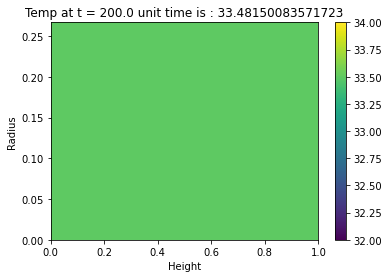

In [9]:
fig = plt.figure()
plt.axes(xlim=(0, outDF["z"].max()), ylim=(0, outDF["r"].max()), xlabel='Height', ylabel='Radius',title="Temp at t = {0} unit time is : {1}".format(str(0.0),str(Tt(0.0)[10][10])))
pcm = plt.pcolormesh(Tt(0.0),vmin=int(outDF["T"].min()-1), vmax=int(outDF["T"].max()+1))
plt.colorbar()

# Function called to update the graphic
def step(i):
    #pcm.set_array(MM[i].ravel())
    pcm.set_array(np.array(Tt(i)).ravel())
    plt.title("Temp at t = {0} unit time is : {1}".format(i,Tt(i)[10][10]))
    plt.draw()
    time.sleep(10)

anim = FuncAnimation(fig, step,outDF["t"].unique().tolist() ,interval=150)
#plt.show()
from IPython.display import HTML
HTML(anim.to_html5_video())